<a href="https://colab.research.google.com/github/KendallScott/QTW/blob/main/Case%20Study%205/Case_Study_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import label_binarize, OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from yellowbrick.classifier import ConfusionMatrix
from sklearn.preprocessing import StandardScaler
from numpy import arange
from sklearn.model_selection import GridSearchCV

#from example SVM notebook
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

Prediction on the Action column, for use with a firewall.

Port is like an address that allows connection like a tv channel.


In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/KendallScott/QTW/main/Case%20Study%205/log2.csv")
df

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18
...,...,...,...,...,...,...,...,...,...,...,...,...
65527,63691,80,13237,80,allow,314,192,122,6,15,4,2
65528,50964,80,13485,80,allow,4680740,67312,4613428,4675,77,985,3690
65529,54871,445,0,0,drop,70,70,0,1,0,1,0
65530,54870,445,0,0,drop,70,70,0,1,0,1,0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [18]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [6]:
df['Source Port'] = df['Source Port'].astype(str)
df['Destination Port'] = df['Destination Port'].astype(str)
df['NAT Source Port'] = df['NAT Source Port'].astype(str)
df['NAT Destination Port'] = df['NAT Destination Port'].astype(str)

In [7]:
df.describe()

,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


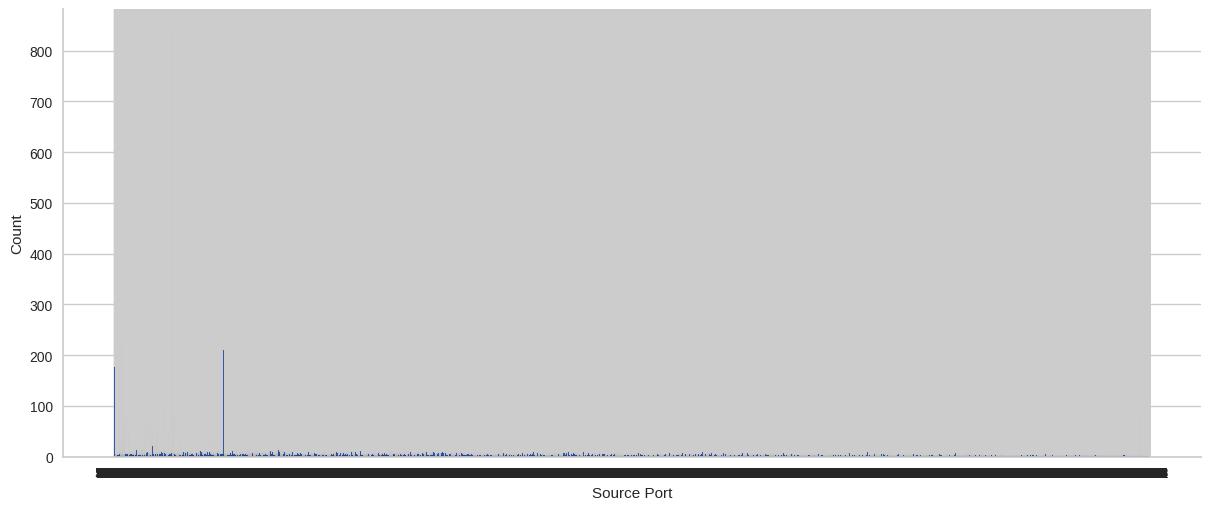

In [58]:
sns.displot(df['Source Port'],
            color = '#0033A0',
            height = 5.27,
            aspect = 12.27 / 5.27)
plt.show()

In [29]:
df[['Source Port','Action']].groupby('Source Port').count()

,Action
Source Port,
0,173
10000,3
10001,2
10002,2
10003,8
...,...
993,19
9957,3
9968,1


There are 22,724 distinct Source Ports in this dataset.

In [56]:
# Make dataframe for model input
X = df.loc[:, df.columns != 'Action']

#one hot encoding categorical variables for model
cols = X.columns
num_cols = X._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

#creating dataframe of categorical columns
cat_df = X[cat_cols]
cat_df = pd.get_dummies(cat_df, columns=cat_df.columns)

#creating dataframe of numeric columns
scaler = StandardScaler()
num_df = scaler.fit_transform(X[num_cols])

X=cat_df.join(pd.DataFrame(num_df,columns=X[num_cols].columns, index=X[num_cols].index))
X

,NAT Source Port_0,NAT Source Port_10000,NAT Source Port_10001,NAT Source Port_10002,NAT Source Port_10005,NAT Source Port_10007,NAT Source Port_10010,NAT Source Port_10011,NAT Source Port_10013,NAT Source Port_10014,...,Source Port_9968,Source Port_9969,Source Port_9997,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,-0.017255,-0.005823,-0.030308,-0.019651,-0.118474,-0.012551,-0.027197
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,-0.016438,-0.005430,-0.029056,-0.016339,-0.161455,-0.009755,-0.023598
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,-0.017244,-0.005817,-0.030293,-0.019651,3.746507,-0.012551,-0.027197
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,-0.016695,-0.005472,-0.029575,-0.017118,-0.161455,-0.010376,-0.024498
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,-0.012773,-0.004077,-0.022799,-0.014001,-0.164761,-0.008823,-0.019550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,-0.017231,-0.005798,-0.030293,-0.018871,-0.168067,-0.011619,-0.026747
65528,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.815823,0.011736,1.842607,0.890740,0.036919,0.293149,1.632037
65529,1,0,0,0,0,0,0,0,0,0,...,0,0,0,-0.017274,-0.005829,-0.030342,-0.019845,-0.217661,-0.012551,-0.027646
65530,1,0,0,0,0,0,0,0,0,0,...,0,0,0,-0.017274,-0.005829,-0.030342,-0.019845,-0.217661,-0.012551,-0.027646


Checking columns that have a high number of 0s (an infrequent categorical column).

In [30]:
Source_Port = []
Source_Port_perc = []

for i in X.columns:
  count = X.loc[X[i]==0,i].count()
  if count > 0:
    print('{}:'.format(i),
          '{}%'.format(np.round(np.divide(count,len(df))*100,2)))
    Source_Port_perc.append(np.round(np.divide(count,len(df))*100,2))
    Source_Port.append(i)

Streaming output truncated to the last 5000 lines.
Source Port_60241: 99.99%
Source Port_60242: 100.0%
Source Port_60243: 100.0%
Source Port_60244: 100.0%
Source Port_60245: 99.99%
Source Port_60246: 99.99%
Source Port_60247: 100.0%
Source Port_60248: 99.99%
Source Port_60249: 100.0%
Source Port_60250: 100.0%
Source Port_60251: 100.0%
Source Port_60252: 100.0%
Source Port_60254: 100.0%
Source Port_60255: 100.0%
Source Port_60256: 100.0%
Source Port_60257: 100.0%
Source Port_60258: 100.0%
Source Port_60259: 100.0%
Source Port_60260: 99.99%
Source Port_60261: 99.99%
Source Port_60262: 100.0%
Source Port_60263: 100.0%
Source Port_60265: 100.0%
Source Port_60266: 100.0%
Source Port_60267: 100.0%
Source Port_60269: 100.0%
Source Port_60270: 99.99%
Source Port_60271: 100.0%
Source Port_60272: 100.0%
Source Port_60273: 100.0%
Source Port_60276: 100.0%
Source Port_60277: 100.0%
Source Port_60278: 100.0%
Source Port_60280: 100.0%
Source Port_60281: 100.0%
Source Port_60282: 100.0%
Source Port_6

In [34]:
Source_Port_df = pd.DataFrame({'Source_Port': list(Source_Port), 'Source_Port_perc': list(Source_Port_perc)}, columns=['Source_Port', 'Source_Port_perc'])
Source_Port_df = Source_Port_df.loc[Source_Port_df['Source_Port_perc'] > 99.8]
Source_Port_df
drop_array = Source_Port_df.Source_Port.unique()

,Source_Port,Source_Port_perc
0,NAT Source Port_0,56.61
1,NAT Source Port_10000,100.00
2,NAT Source Port_10001,100.00
3,NAT Source Port_10002,100.00
4,NAT Source Port_10005,100.00
...,...,...
57677,Source Port_993,99.97
57678,Source Port_9957,100.00
57679,Source Port_9968,100.00
57680,Source Port_9969,100.00


In [ ]:
i=0
while i < len(drop_array):
  X = X.drop([drop_array[i]], axis=1)
  i+=1

In [ ]:
X.describe()

In [ ]:
model = LinearSVC(max_iter=100000,tol=0.01)
X_train,X_test, y_train,y_test = train_test_split(X,y_alt)

In [24]:
#creating dataframe to find where there is high readmitted rates for a variable
y_alt = df[['Action']]
y_alt = pd.get_dummies(y_alt, columns=y_alt.columns)

In [25]:
y_alt

,Action_allow,Action_deny,Action_drop,Action_reset-both
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
65527,1,0,0,0
65528,1,0,0,0
65529,0,0,1,0
65530,0,0,1,0
